## Using SAS DLPy to Define SAS Viya Model Learning Rate Policies

When creating and training deep learning neural network models, one of the most important hyperparameters to configure for good performance is the learning rate.  This example notebook demonstrates how you can use SAS DLPy to specify different predefined learning rate policies for your SAS Viya deep learning models. This notebook also shows you how to specify your own customized learning rate policy using the SAS Viya FCMP function utility.

### Contents

- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Computing Environment for Modeling](#getReady)
    - [Download the Image Data](#downloadData)
    - [Import Required Python and SAS DLPy Modules](#importPythonDLPy)
- [Launch SAS CAS Session](#LaunchCAS)
- [Use SAS DLPy to Create a Simple SAS Viya ResNet Network](#CreateResNet)
- [Load the Image Data into SAS CAS](#LoadImageData)
- [Define the Model Learning Rate Hyperparameter](#DefineLR)
    - [Specify Step Learning Rate](#StepLR)
    - [Specify Cyclic Learning Rate Scheduler](#CyclicLR)
    - [Specify Reduce Learning Rate on Plateau](#ReduceLR_Plat)
    - [Specify Customized Learning Rate Policy](#CustomLR)

<a id = "ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. If the client and server in your environment do not have access to a common file system, you will need to copy or transfer files between client and server during this example.

In [1]:
# This code defines path variables that contain path specifications to  
# the client and server model files and image root directories.

# Server Learning Rate root location (your path will be different)
server_learning_rate_root = r'/cas/DeepLearn/UserID/Learning_Rate/' 

# Server Learning Rate Image root location (your path will be different)
server_image_root = r'/cas/DeepLearn/UserID/Learning_Rate/Giraffe_Dolphin' 

<a id = "getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources that you will need and configure your local computing environment for this notebook example. Performing these tasks in advance means you can run the example without multiple stops to locate and download necessary resources. This approach enables you to focus on how to use SAS DLPy to complete the modeling task in this notebook.

<a id="downloadData"></a>

#### Download the Image Data

All of the examples use a small toy data set that contains dolphin or giraffe images for the classification tasks. You can download the dolphin and giraffe image data from the SAS DLPy GitHub site [here.](https://github.com/sassoftware/python-dlpy/tree/master/dlpy/tests/datasources/giraffe_dolphin_small). Create a folder named `Giraffe_Dolphin` in the server location that you saved as `server_image_root`, and use this folder to contain the `Dolphin` and `Giraffe` image subfolders. The notebook example expects the following folder structures:

server_learning_rate_root
 * Giraffe_Dolphin  (server_image_root)     
       * Dolphin
           * Dolphin image 1
           * Dolphin image 2
           * ...  
       * Giraffe
           * Giraffe image 1
           * Giraffe image 2
           * ...

<a id = "importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Modules

After copying the input image data to your server, configure your client computing environment for image captioning modeling using Python and SAS DLPy. 

Import the various Python and SAS DLPy modules that this notebook uses. Begin by importing the SAS Scripting Wrapper for Analytic Transfer (SWAT). SWAT is the Python interface to SAS CAS. You can find more detailed information about starting a SAS CAS session with the SWAT package [here](https://sassoftware.github.io/python-swat/getting-started.html). 

Import the SAS DLPy modules and functions that are used to create the CNN and RNN models in this notebook. The DLPy `ImageTable` module makes it easier to load images from a folder into a SAS CAS table. The DLPy `applications` module contains parameters for the pre-built VGG-16 CNN model that the notebook uses to perform image feature extraction.

The `image_captioning` module contains the functions that are necessary for building the RNN image captioning model and to create the captioned image table that will be used for training.


In [2]:
# Import required Python utilities 
# and SAS DLPy modules

import swat
import sys
import dlpy
from dlpy.layers import *
from dlpy.model import *
from dlpy.images import ImageTable
from dlpy.sequential import Sequential
from dlpy.lr_scheduler import *

<a id = "LaunchCAS"></a>

### Launch SAS CAS Session

SAS DLPy requires a running SAS CAS server and the SAS Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. You can choose the port number you want to use. By default SAS uses '5570' for a portID. 

Note: For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [3]:
# Launch SAS CAS session
host_name='your-server.unx.your-company.com'
port_number='5570'

sess = swat.CAS(host_name, port_number)

<a id = "CreateResNet"></a>

### Use SAS DLPy to Create a Simple SAS Viya ResNet Network

ResNet models are a family of models that were developed as backbones for convolutional neural networks performing computer vision tasks, such as image classification. The SAS DLPy API includes complete ResNet model architectures, but you can also use DLPy to define a simple ResNet model from scratch at the block level.

The following code uses SAS DLPy to create a simple ResNet CNN model named `resnet_like_model`.


In [4]:
# Define convolution blocks

def conv_block(x, filters, size, stride=1, mode='same', act=True):
    x = Conv2d(filters, size, size, act='identity', include_bias=False, stride=stride)(x)
    x = BN(act='relu' if act else 'identity')(x)
    return x

In [5]:
# Define residual blocks

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, 2)
    x = conv_block(x, nf, 3, 1, act=False)
    return Res()([x, ip])

In [6]:
# Define input layer, shape, and scale
inp_resnet= Input(3, 112, 112, scale = 1.0 / 255, name='InputLayer_1')

# 2D Convolution and Pooling layers
x=conv_block(inp_resnet, 64, 9, 1)
for i in range(4): x=res_block(x)
x=Conv2d(20, 9, 9, act='tanh')(x)
x=Pooling(7, 7)(x)

# Output layer
output = OutputLayer(n=2)(x)

# Name and compile the model 
resnet_like_model = Model(sess, inputs = inp_resnet, outputs = output)
resnet_like_model.compile()

NOTE: Model compiled successfully.


Use the DLPy `plot_network()` function to display a DAG of the ResNet model `resnet_like_model` you just created:

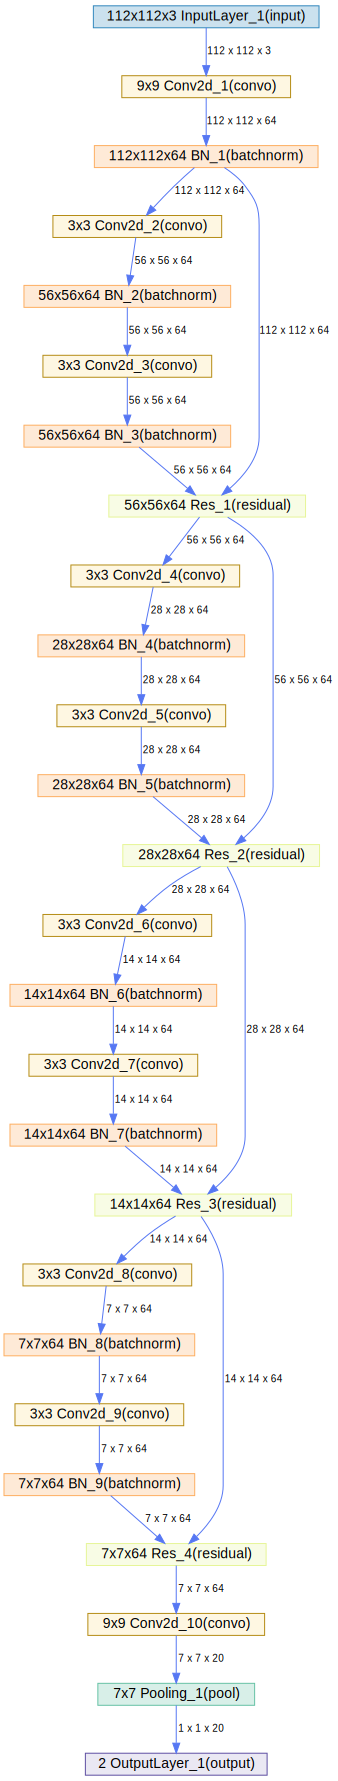

In [7]:
resnet_like_model.plot_network()

<a id = "LoadImageData"></a>

### Load the Image Data into SAS CAS

This step loads the server-side Giraffe and Dolphin image data that you downloaded from GitHub and saved under `server_image_root` into SAS CAS as a table named `my_images`. All of the images in the table are resized to uniform dimensions of 112 px by 112 px.

In [8]:
# Point to the image path stored in server_image_root 
img_path = server_image_root

# Load the files in the image path to table my_images
my_images = ImageTable.load_files(sess, path=img_path)

# Resize all images to 112 px by 112 px
my_images.resize(112)

<a id = "DefineLR"></a>

### Define the Model Learning Rate Hyperparameter

The example thus far has used SAS DLPy to create a simple ResNet image classification model and created a 112 x 112 input image table in SAS CAS. Now it is time to consider how to define the best learning rate for this neural network model.

The SAS DLPy API includes a choice of predefined learning rate policies you can specify:

- FixedLR
- StepLR
- MultiStepLR
- PolynomialLR
- ReduceLROnPlateau
- CyclicLR

SAS DLPy also allows you to create your own custom learning rate policy using the SAS FCMP function compiling procedure.

<a id = "StepLR"></a>

#### Specify a Step Learning Rate

The following code uses SAS DLPy to specify and configure step learning rate `StepLR` hyperparameters for the model `resnet_like_model`.

In [9]:
# Specify Step Learn Rate parameters
lr_scheduler = StepLR(learning_rate=0.0001, 
                      gamma=0.1, 
                      step_size=2
                     )

# Momentum solver using StepLR 
solver = MomentumSolver(lr_scheduler=lr_scheduler, 
                        clip_grad_max = 100, 
                        clip_grad_min = -100
                       )

# Optimizer and GPU settings
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=16, 
                      log_level=3, 
                      max_epochs=5, 
                      reg_l2=0.0005
                     )

gpu = Gpu(devices=[0])

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


Now use the SAS DLPy `fit()` function to train the model `resnet_like_model` with the specified hyperparameter settings and the input data in CAS table `my_images`:

In [10]:
# Train the model 
resnet_like_model.fit(data=my_images, 
                      n_threads=4, 
                      record_seed=13309, 
                      optimizer=optimizer,
                      gpu=gpu, 
                      log_level=2
                     )

NOTE: Inputs=_image_ is used
NOTE: Training from scratch.
NOTE: Using your-server.unx.your-company.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 415358.
NOTE:  The approximate memory cost is 115.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.24 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64   0.0001            1.439     0.5938     0.

,Descr,Value
0,Model Name,model_8zia1w
1,Model Type,Convolutional Neural Network
2,Number of Layers,26
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,1
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Residual Layers,4


The model `resnet_like_model` when trained with a `StepLR` learning rate policy, has a final learning rate of 0.000001, a loss value of 1.103452, and a fit error of 0.453125. We can compare these statistics to those of other versions of this model that use different learning rate policies.

<a id = "CyclicLR"></a>

#### Specify Cyclic Learning Rate Scheduler


The following code uses SAS DLPy to specify and configure cyclic learning rate `CyclicLR` hyperparameters for the model `resnet_like_model`.


In [11]:
# Specify Cyclic Learn Rate parameters
lr_scheduler = CyclicLR(conn=sess, 
                        data=my_images, 
                        max_lr=0.01, 
                        batch_size=1, 
                        factor=2,
                        learning_rate=0.0001
                       )

# Momentum solver using CyclicLR 
solver = MomentumSolver(lr_scheduler = lr_scheduler,
                        clip_grad_max = 100, 
                        clip_grad_min = -100
                       )

# Optimizer and GPU settings
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=16, 
                      log_level=3, 
                      max_epochs=50, 
                      reg_l2=0.0005
                     )

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


Now use the SAS DLPy `fit()` function to train the model `resnet_like_model` with the specified hyperparameter settings and the input data in CAS table `my_images`:

In [12]:
# Train the model
resnet_like_model.fit(data=my_images, 
                      n_threads=4, 
                      record_seed=13309, 
                      optimizer=optimizer,
                      gpu=gpu, 
                      log_level=2)

NOTE: Inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: Using your-server.unx.your-company.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 415358.
NOTE:  The approximate memory cost is 115.00 MB.
NOTE:  Loading weights cost       0.01 (s).
NOTE:  Initializing each layer cost       0.91 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64   0.0001             1.41     

NOTE:      1    64 0.000153          0.02078          0     0.2984     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  20       0.0002            0.02          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00505          0.01793          0     0.2983     0.05
NOTE:      1    64 0.005103          0.01861          0     0.2983     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  21       0.0051         0.01827          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     0.01          0.01453          0     0.2983     0.05
NOTE:      1    64 0.009947          0.06549    0.01563     0.2983     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  22       0.0099         0.04001   0.007813     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)

NOTE:      1    64 0.000153         0.005557          0     0.2972     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  44       0.0002         0.03251    0.01563     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00505         0.007041          0     0.2972     0.05
NOTE:      1    64 0.005103         0.007628          0     0.2972     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  45       0.0051        0.007334          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     0.01          0.01899          0     0.2972     0.05
NOTE:      1    64 0.009947         0.008192          0     0.2972     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  46       0.0099         0.01359          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)

,Descr,Value
0,Model Name,model_8zia1w
1,Model Type,Convolutional Neural Network
2,Number of Layers,26
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,1
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Residual Layers,4


The model `resnet_like_model` when trained with a `CyclicLR` learning rate policy, has a final learning rate of 0.005103, a loss value of 0.026172, and a fit error of 0.007812.  By comparision, the same model trained using the `StepLR` learning rate policy had a final learning rate of 0.000001, a loss value of 1.103452, and a fit error of 0.453125.

When you compare the fit and error statistics, the `resnet_like_model` that was trained using the `CyclicLR` learning rate policy outperforms the model that was trained using the `StepLR` learning rate policy.

<a id = "ReduceLR_Plat"></a>

#### Specify Reduce Learning Rate on Plateau

The following code uses SAS DLPy to specify and configure the reduce learning rate on plateau `ReduceLROnPlateau` hyperparameters for the model `resnet_like_model`.

In [13]:
# Specify ReduceLROnPlateau hyperparameter settings
lr_scheduler = ReduceLROnPlateau(conn=sess, 
                                 cool_down_iters=2, 
                                 gamma=0.1, 
                                 learning_rate=0.01, 
                                 patience=3
                                )

# Specify Momentum solver parameters
solver = MomentumSolver(lr_scheduler = lr_scheduler,
                        clip_grad_max = 100, 
                        clip_grad_min = -100
                       )

# Specify optimizer settings
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=16, 
                      log_level=3, 
                      max_epochs=50, 
                      reg_l2=0.0005
                     )

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [14]:
# Train the model
resnet_like_model.fit(data=my_images, 
                      n_threads=4, 
                      record_seed=13309, 
                      optimizer=optimizer,
                      gpu=gpu, 
                      log_level=2)

NOTE: Inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: Using your-server.unx.your-company.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 415358.
NOTE:  The approximate memory cost is 115.00 MB.
NOTE:  Loading weights cost       0.01 (s).
NOTE:  Initializing each layer cost       0.97 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     0.01           0.1022     

NOTE:      1    64  0.00001           0.0224          0     0.2966     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  20         1E-5         0.04548   0.007813     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00001          0.03653    0.01563     0.2966     0.05
NOTE:      1    64  0.00001          0.03278          0     0.2966     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  21         1E-5         0.03466   0.007813     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00001          0.01072          0     0.2966     0.05
NOTE:      1    64  0.00001         0.006113          0     0.2966     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  22         1E-5        0.008419          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)

NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  46         1E-9         0.04077   0.007813     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     1E-9           0.1211    0.07813     0.2966     0.05
NOTE:      1    64     1E-9         0.007988          0     0.2966     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  47         1E-9         0.06454    0.03906     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64    1E-10          0.01762          0     0.2966     0.05
NOTE:      1    64    1E-10          0.06928    0.03125     0.2966     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  48        1E-10         0.04345    0.01563     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64    1E-10          0.01124          0     0.2966     0.05

,Descr,Value
0,Model Name,model_8zia1w
1,Model Type,Convolutional Neural Network
2,Number of Layers,26
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,1
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Residual Layers,4


The model `resnet_like_model`, when trained with a `ReduceLROnPlateau` learning rate policy, has a final learning rate of 1.000000e-10, a loss value of 0.008770, and a fit error of 0.00.  By comparision, the same model trained with the `CyclicLR` learning rate policy has a final learning rate of 0.005103, a loss value of 0.026172, and a fit error of 0.007812.  The same model trained with the `StepLR` learning rate policy had a final learning rate of 0.000001, a loss value of 1.103452, and a fit error of 0.453125.

When you compare the fit and error statistics, the model that was trained using the `ReduceLROnPlateau` learning rate policy outperforms the models that were trained using the `CyclicLR` and `StepLR` learning rate policies.

<a id = "CustomLR"></a>

#### Specify Customized Learning Rate Policy

The SAS DLPy API also provides a flexible approach to defining your own version of a learning rate policy. DLPy enables you to use the SAS FCMP function compiler to create your own custom learning rate policies.

The following SAS function compiler code creates a custom learning rate policy called `reduce_lr_on_plateau`:

In [15]:
cool_down_iters = 5
patience = 1
sess.addRoutines(
            routineCode = '''
                        function reduce_lr_on_plateau(rate, initRate, gamma, loss[*]);
                            len = dim(loss);
                            temp_rate = initRate;
                            cool_down_counter = {0};
                            best = loss[1];
                            do i=1 to len;
                    
                                if loss[i] < best then do;
                                    best = loss[i];
                                    bad_epoch = 0;
                                end;
                                else bad_epoch = bad_epoch + 1;
                    
                                if cool_down_counter > 0 then do;
                                    cool_down_counter = cool_down_counter - 1;
                                    bad_epoch = 0;
                                end;
                    
                                if bad_epoch > {1} then do;
                                    temp_rate = temp_rate * gamma;
                                    cool_down_counter = {0};
                                    bad_epoch = 0;
                                end;
                            end;
                            rate = temp_rate;
                            put rate=;
                            return(rate);
                        endsub;
                        '''.format(cool_down_iters, patience),
            package = 'pkg',
            funcTable = dict(name = 'reduce_lr_on_plateau', replace = 1))

+ Elapsed: 0.00395s, user: 0.00384s, sys: 9e-05s, mem: 3.34mb

You custom FCMP function can be called by invoking the FCMP function name while setting `fcmp_learning_rate`.

In [16]:
# Specify the custom LR function 
# and settings in 'fcmp_learning_rate'
lr_scheduler = FCMPLR(conn=sess, 
                      fcmp_learning_rate='reduce_lr_on_plateau',
                      learning_rate = 0.01, 
                      gamma = 0.1
                     )

# Specify Momentum solver settings
solver = MomentumSolver(lr_scheduler = lr_scheduler,
                        clip_grad_max = 100, 
                        clip_grad_min = -100
                       )

# Specify optimizer settings
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=16, 
                      log_level=3, 
                      max_epochs=50, 
                      reg_l2=0.0005
                     )

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [17]:
# Train the model using the custom
# FCMP learning rate settings
resnet_like_model.fit(data=my_images, 
                      n_threads=4, 
                      record_seed=13309, 
                      optimizer=optimizer,
                      gpu=gpu, 
                      log_level=2
                     )

NOTE: Inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: Using your-server.unx.your-company.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 415358.
NOTE:  The approximate memory cost is 115.00 MB.
NOTE:  Loading weights cost       0.01 (s).
NOTE:  Initializing each layer cost       1.08 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     0.01           0.3265     

NOTE:      1    64   0.0001          0.01125          0     0.2962     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  20       0.0001         0.01021          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00001          0.01308          0     0.2962     0.05
NOTE:      1    64  0.00001          0.01133          0     0.2962     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  21         1E-5         0.01221          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00001         0.005627          0     0.2962     0.05
NOTE:      1    64  0.00001         0.007459          0     0.2962     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  22         1E-5        0.006543          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)

NOTE:      1    64     1E-8          0.00606          0     0.2962     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  44         1E-8        0.008058          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     1E-8          0.00788          0     0.2962     0.05
NOTE:      1    64     1E-8          0.01028          0     0.2962     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  45         1E-8        0.009079          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     1E-8         0.009063          0     0.2962     0.05
NOTE:      1    64     1E-8         0.008965          0     0.2962     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  46         1E-8        0.009014          0     0.09
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)

,Descr,Value
0,Model Name,model_8zia1w
1,Model Type,Convolutional Neural Network
2,Number of Layers,26
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,1
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Residual Layers,4


The model `resnet_like_model`, when trained with a custom-written SAS FCMP function `reduce_lr_on_plateau` learning rate policy, has a final learning rate of 1.000000e-09, a loss value of 0.007257, and a fit error of 0.00.  

By comparison:

- The same model trained with the `ReduceLROnPlateau` learning rate policy has a final learning rate of 1.000000e-10, a loss value of 0.008770, and a fit error of 0.00. 
- The same model trained with the `CyclicLR` learning rate policy has a final learning rate of 0.005103, a loss value of 0.026172, and a fit error of 0.007812. 
- The same model trained with the `StepLR` learning rate policy has a final learning rate of 0.000001, a loss value of 1.103452, and a fit error of 0.453125.

When you compare the fit and error statistics, the model that was trained using the custom-written SAS FCMP function `reduce_lr_on_plateau` learning rate policy outperforms the models that were trained using the `ReduceLROnPlateau`, `CyclicLR`, and `StepLR` learning rate policies.

In [18]:
sess.endsession()

+ Elapsed: 0.000101s, sys: 9.5e-05s, mem: 0.204mb